# Decompose HSC observed QSO image

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
    - note: if python2 used, lenstronomy version 1.3.0 version is recommended (pip install lenstronomy==1.3.0 --user)
- regions (pip install regions)
- photutils (pip install photutils)

This notebook has been tested with decompsofile ==  0.1.0

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'decomprofile_HST_QSO.ipynb', only that the noise_map, PSF are input to the fittings. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: \url, 
fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/QSO/000017.88+002612.6_HSC-I_psf.fits')

Estimating the background light ... ... ...
Plot target cut out zoom in:


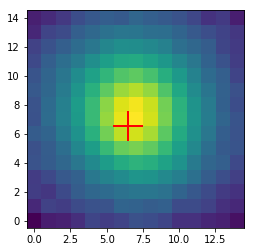

/Users/Dartoon/.local/lib/python2.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


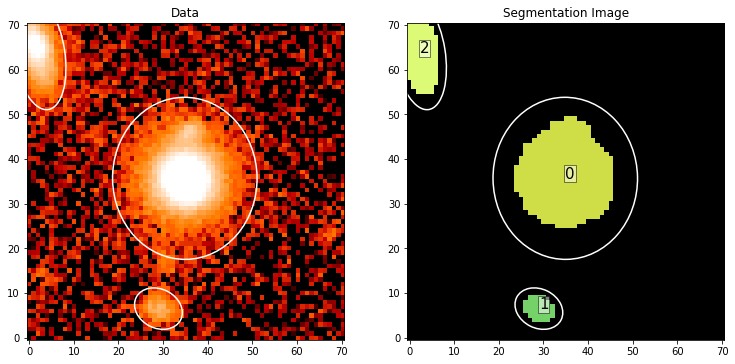

 id xcentroid ycentroid     source_sum       orientation    area
       pix       pix                             rad        pix2
--- --------- --------- ------------------ --------------- -----
  1     28.97      6.48 14.853843816758022 -0.469750409826  34.0
  0     34.88     35.66  945.7610077660055  -1.55314988603 410.0
  2      2.29     63.73 103.17427701653905  -1.41225999677 102.0
Input directly the a obj idx to mask, use space between each id:
2


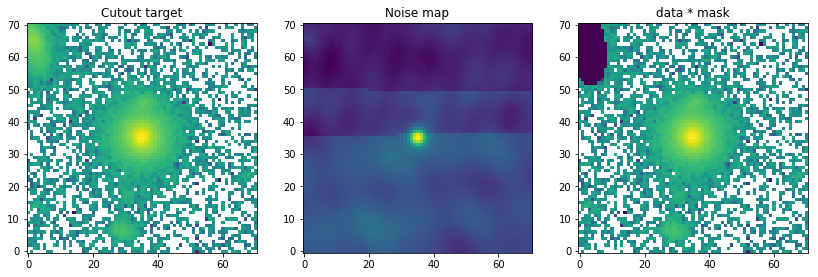

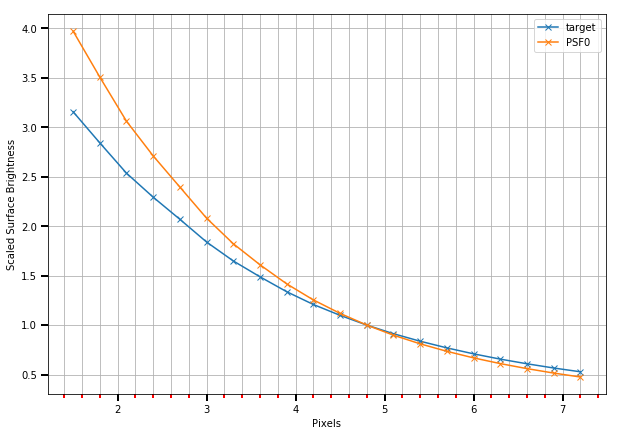

The data_process is ready to go to pass to FittingSpecify!


In [2]:
from decomprofile.data_process import DataProcess

#RA, DEC information of the QSO:
QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Manually input the fov noise map:
data_process.fov_noise_map = err_data

#Generate the fitting materials
data_process.generate_target_materials(radius=35, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Manually input the PSF:
data_process.PSF_list = [PSF]

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )


#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


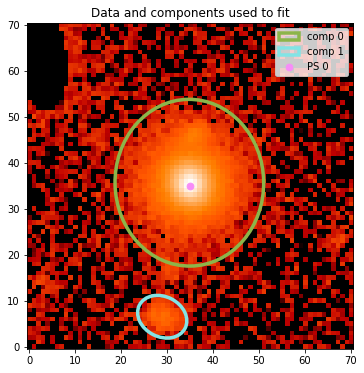

In [3]:
#Start to produce the class and params for lens fitting.
#For more details, see notebook decomprofile_HST_QSO.ipynb
from decomprofile.fitting_specify import FittingSpeficy
fit_sepc = FittingSpeficy(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
#Using following line: want to fix Sersic_n as 4 for the source_id = 0, and if want to fix the QSO and host center:
# fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]])

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

fit_sepc.build_fitting_seq()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
max iteration reached! stoping
(-1.4993652583143642, 'reduced X^2 of best position')
(-3652.453769253791, 'logL')
(4872.0, 'effective number of data points')
([], 'lens result')
([{'R_sersic': 0.9156794533644617, 'n_sersic': 1.5998090440015895, 'center_x': 0.04764556086810599, 'center_y': 0.1079436735938881, 'amp': 1, 'e1': -0.0671815038224824, 'e2': 0.0758133105710904}, {'R_sersic': 0.37611553309454715, 'n_sersic': 0.3007868983400199, 'center_x': 0.994471297553878, 'center_y': -4.787166536726834, 'amp': 1, 'e1': 0.201314667972161, 'e2': 0.13760186826098386}], 'source result')
([], 'lens light result')
([{'point_amp': [1], 'ra_image': array([0.0228138]), 'dec_image': array([0.04979107])}], 'point source result')
({}, 'special param result')
(140.33718705177307, 'time used for ', 'PSO')


/Users/Dartoon/.local/lib/python2.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Computing the MCMC...
('Number of walkers = ', 140)
('Burn-in iterations: ', 100)
('Sampling iterations:', 30)
(151.5072479248047, 'time taken for MCMC sampling')
(291.892, 'total time taken for the overall fitting (s)')
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
(4200, 'MCMC samplers in total, finished translate:', 0)
(4200, 'MCMC samplers in total, finished translate:', 1000)
(4200, 'MCMC samplers in total, finished translate:', 2000)
(4200, 'MCMC samplers in total, finished translate:', 3000)
(4200, 'MCMC samplers in total, finished translate:', 4000)


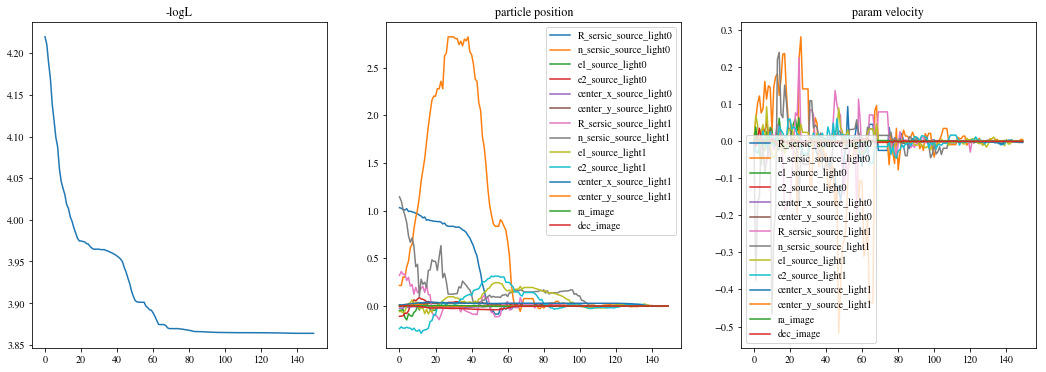

<Figure size 432x288 with 0 Axes>

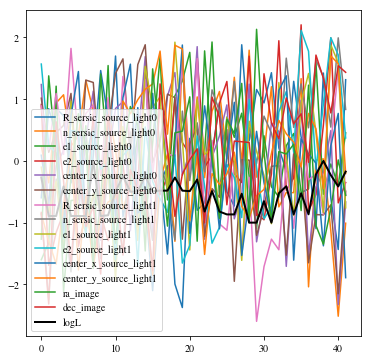

(-1.4943953530988408, 'reduced X^2 of all evaluated imaging data combined.')
('reduced chi^2 of data ', 0, '= ', 1.494395353098841)


/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:35: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:118: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
/Users/Dartoon/.local/lib/python2.7/site-packages/lenstronomy/Plots/model_band_plot.py:501: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


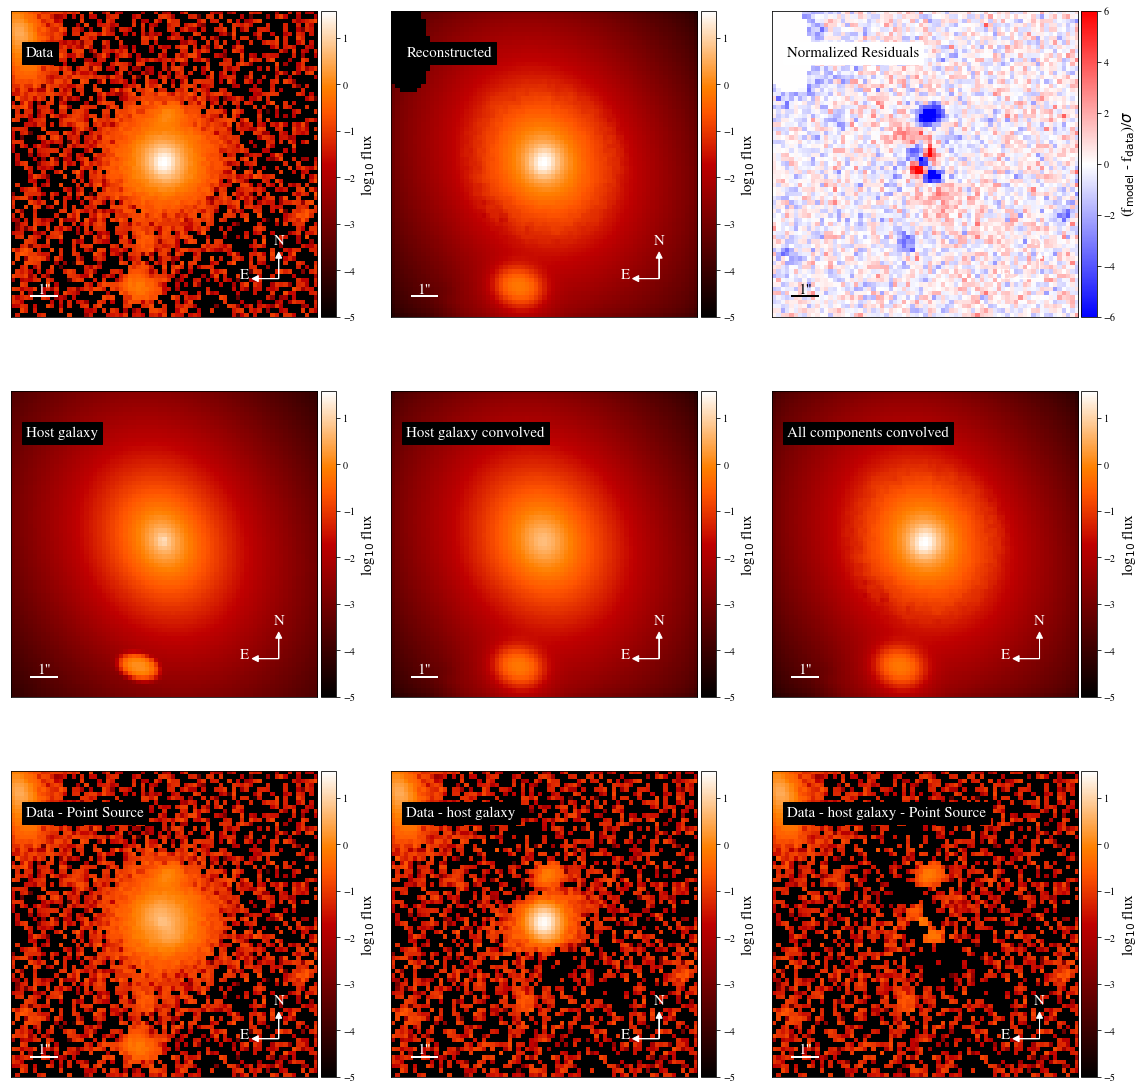

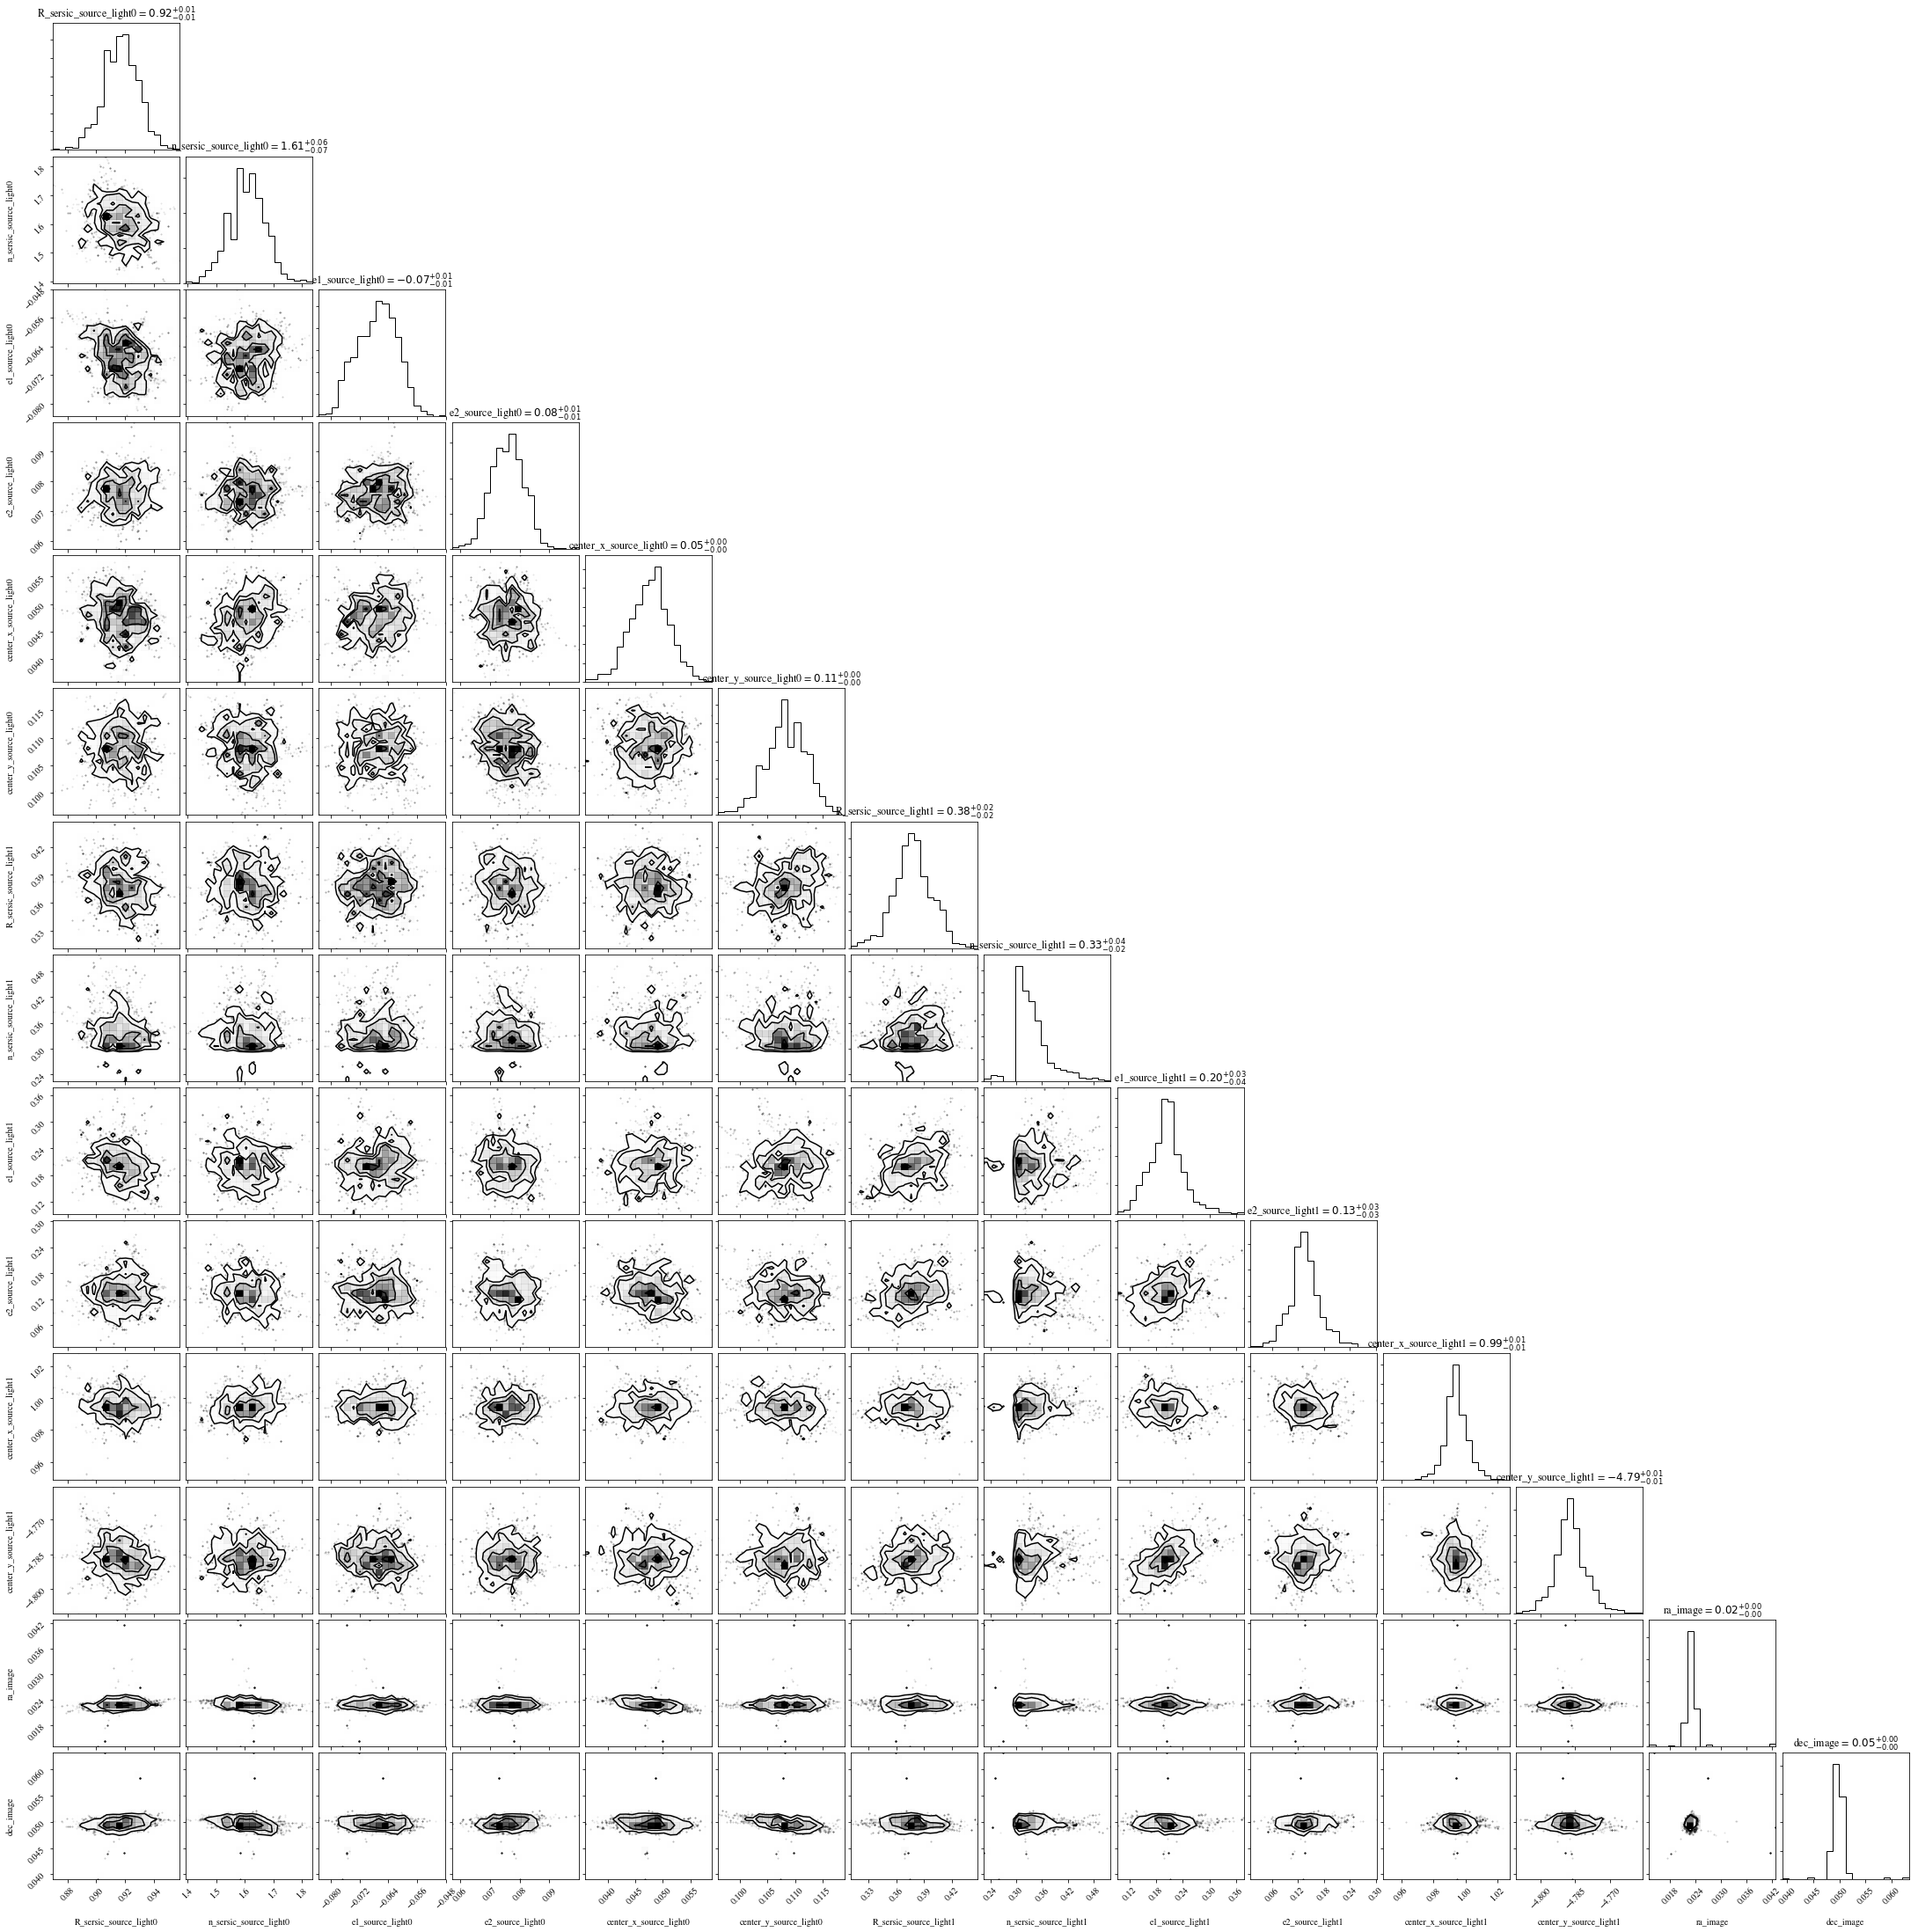

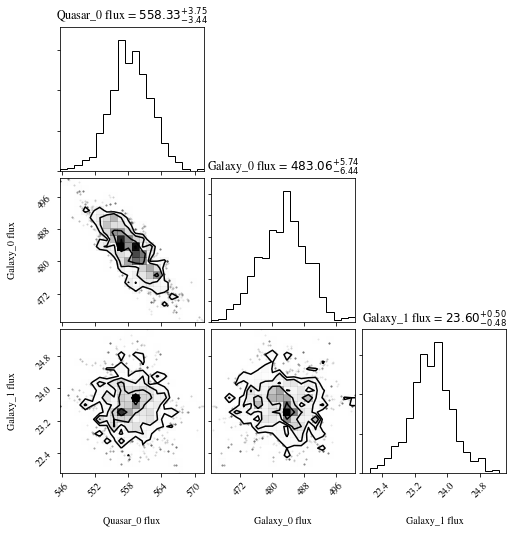

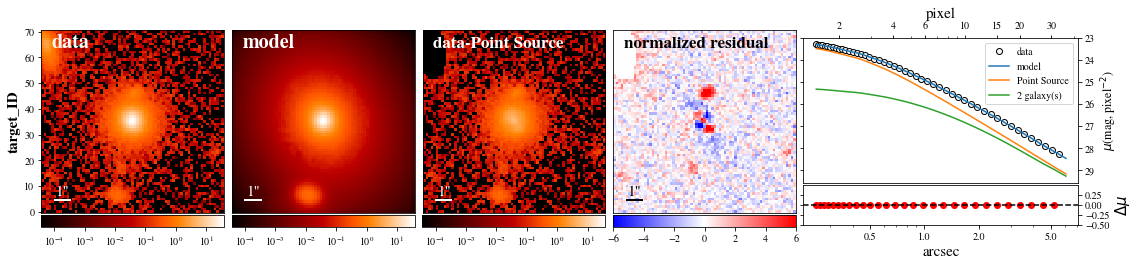

In [4]:
#Setting the fitting method and run.
from decomprofile.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HSC_result')

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         [0.8, 50, 50] would input: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         [50, 100, 10, 0.1] would input: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()

#Calculate the magnitude for each component, and translate e1, e1 to q, theta.
fit_run.translate_result()

#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

In [5]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'R_sersic': 0.9155877892477704,
  'amp': 47.967671679334565,
  'center_x': 0.04793580158120009,
  'center_y': 0.10949104076712601,
  'e1': -0.0671492083216938,
  'e2': 0.07819283181727892,
  'flux_sersic_model': 597.7221177997612,
  'flux_within_frame': 484.71408737310685,
  'magnitude': 20.286285895197445,
  'n_sersic': 1.6343577262662043,
  'phi_G': 1.140178266939305,
  'q': 0.8131238713349631},
 {'R_sersic': 0.3716447689930462,
  'amp': 34.96307971333924,
  'center_x': 0.9931114814139973,
  'center_y': -4.783070785202506,
  'e1': 0.20505645441663384,
  'e2': 0.1305068163309829,
  'flux_sersic_model': 38.94693141812706,
  'flux_within_frame': 23.439489086031276,
  'magnitude': 23.575129647327657,
  'n_sersic': 0.306430062253403,
  'phi_G': 0.2833929756207737,
  'q': 0.608927429828299}]